Before starting the application please down load the FLIC zip file from https://bensapp.github.io/flic-dataset.html

# **1. Implementation of CNN based Pose Estimation Model**

In [ ]:
#Mounting my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzipping the pose estimation dataset and joint coordinates
!unzip '/content/drive/My Drive/FLIC DATASET.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test106.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test107.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test108.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test109.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test11.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test110.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test111.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test112.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test113.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test114.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test115.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test116.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test117.jpg  
  inflating: /content/FLIC DATASET/Pose_Dataset/test/test118.jpg  
  inflating:

In [ ]:
#Unmounting the drive since it causes training to be slow.
from google.colab import drive
drive.flush_and_unmount()

import libraries

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, GlobalMaxPooling2D, Input, Flatten, BatchNormalization, MaxPool2D , add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import EarlyStopping
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os, random
import pandas as pd
import cv2 as cv

from keras.models import model_from_json
import cv2
from keras import backend as K
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

displaying the train image

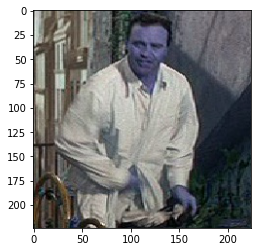

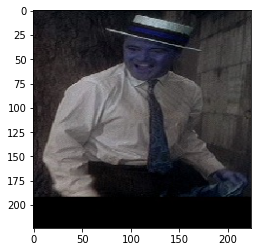

In [ ]:
#Defining the test and train dataset directories
train_dir = "/content/FLIC DATASET/Pose_Dataset/train"
test_dir = '/content/FLIC DATASET/Pose_Dataset/test'

# Initializing image size as 224*224 since the pre-trained model VGG16 only accepts input size of 224*224*3
img_width, img_height= [224,224]

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()

#Randomly displaying an image from the train and test dataset
for i in range(0,1):
    show_pictures(train_dir)
    show_pictures(test_dir)

preprocessing

In [ ]:
#Displaying the number of images
imagePaths = list(paths.list_images("/content/FLIC DATASET/Pose_Dataset/train"))
len(imagePaths)

4429

In [ ]:
#creating the train dataframe
train_label = pd.read_csv("/content/FLIC DATASET/Pose_Dataset/train_joints_coords.csv", header=None)

#creating the test dataframe
test_label = pd.read_csv("/content/FLIC DATASET/Pose_Dataset/test_joints_coords.csv",header = None)

print("The shape of train dataset is {}".format(train_label.shape))
print("The shape of test dataset is {}".format(test_label.shape))

train_label.head()

The shape of train dataset is (4429, 15)
The shape of test dataset is (574, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,train0.jpg,190,160,149,137,151,84,122,34,47,77,31,141,31,190
1,train1.jpg,192,137,148,122,138,77,109,40,47,79,36,140,34,184
2,train2.jpg,190,139,147,116,139,72,103,33,37,82,33,148,47,188
3,train3.jpg,185,157,145,134,141,82,114,41,38,85,32,149,76,184
4,train4.jpg,44,182,38,139,53,83,119,38,155,91,172,139,195,177


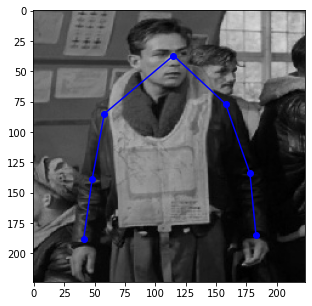

In [ ]:
#Loading an Image
train_imgs = "/content/FLIC DATASET/Pose_Dataset/train"
test_imgs = "/content/FLIC DATASET/Pose_Dataset/test"
img = cv2.imread(train_imgs +'/train15.jpg')

#Storing Respective Coordinates of imgage
cord=train_label.iloc[15,1:].values

# Seperating 'x' and 'y' points in list named x,y respectively.
x=[];y=[]
for i in range(0, len(cord), 2):
  x.append(cord[i])
  y.append(cord[i+1])

#Plotting using Matplotlib
plt.figure(figsize= (5,5))
plt.imshow(img)
plt.plot(x,y, 'bo-')

image generator

In [ ]:
#Initializing
batch_size=40
target_size=(224,224)

#I am taking 10% of the train dataset for validation
generator=ImageDataGenerator(validation_split=0.10)

#training generator
train_generator = generator.flow_from_dataframe(train_label, directory = train_imgs,
                                                x_col=0 ,y_col=list(np.arange(1,15,1)),
                                                class_mode= 'raw', target_size= (224,224),
                                                subset='training',batch_size=batch_size)
#validation generator
val_generator = generator.flow_from_dataframe(train_label, directory = train_imgs,
                                              x_col=0 ,y_col=list(np.arange(1,15,1)),
                                              class_mode= 'raw', target_size= (224,224),
                                              subset='validation',batch_size=batch_size)
#test generator
generator=ImageDataGenerator()
test_generator = generator.flow_from_dataframe(test_label, directory = test_imgs,x_col=0 ,y_col=list(np.arange(1,15,1)), class_mode= 'raw', target_size= (224,224),batch_size=batch_size)

Found 3987 validated image filenames.
Found 442 validated image filenames.
Found 574 validated image filenames.


pose estimation model architecture

In [ ]:
#For transfer learning I am using VGG16 as the pretrained base model
conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape= (224,224,3))

for layer in conv_base.layers:
    layer.trainable= False   #Here I am making the layers of the pretrained model as Non-Trainable

#Creating the model to be concatenated to the VGG16 model
def top_model():

    top_model = Sequential()
    top_model.add(Conv2D(64,(3,3), activation='relu', padding = 'same', input_shape=conv_base.output_shape[1:]))
    top_model.add(BatchNormalization())
    top_model.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
    top_model.add(Flatten())
    top_model.add(Dense(4096, activation='relu'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.5))
    top_model.add(Dense(14//ns, activation='relu'))

    model = Sequential()
    for layer in conv_base.layers:
        model.add(layer)     #Iterating through all the layers of VGG16 and adding them to a new model
    model.add(top_model)     #Concatenating the Top model to the new mode
    return model

def create_model(n):
    outputs=[]
    for i in range(1,n+1):
        globals()[f'model_{i}'] = top_model()

        outputs.append(globals()[f'model_{i}'].output)

    merged= add(outputs)
    output= Dense(14, activation='relu', kernel_initializer= 'Ones')(merged)
    final_model = Model(conv_base.input,output)

    return final_model

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
ns=2 #Number of groups in which the model need to be build
model_final = create_model(ns)   # ns: as Number of Stages  for training.
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[1][0]               
                                                                 block1_conv1[2][0]               
______________________________________________________________________________________________

pose estimation model training

In [ ]:
#Custom Metrics R2_Score
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

optimizer= Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
loss='mean_squared_error'
metrics=[coeff_determination]
model_final.compile(optimizer= optimizer, loss=loss,  metrics=metrics)

In [ ]:
early_stopping_monitor= EarlyStopping(monitor='coeff_determination', min_delta=0, patience=10,
                                      verbose=0, mode= 'max', baseline=None, restore_best_weights=True)

In [ ]:
history = model_final.fit(train_generator, validation_data=val_generator, epochs=52,
                         callbacks=[early_stopping_monitor],
                         steps_per_epoch= train_generator.samples//batch_size,
                         validation_steps= val_generator.samples//batch_size)

Epoch 1/52
99/99 [==============================] - 124s 797ms/step - loss: 3251.3904 - coeff_determination: -0.0871 - val_loss: 3381.0181 - val_coeff_determination: -0.1239
Epoch 2/52
99/99 [==============================] - 71s 714ms/step - loss: 1863.4366 - coeff_determination: 0.3752 - val_loss: 1777.0640 - val_coeff_determination: 0.4100
Epoch 3/52
99/99 [==============================] - 71s 713ms/step - loss: 1345.1165 - coeff_determination: 0.5487 - val_loss: 1279.3362 - val_coeff_determination: 0.5752
Epoch 4/52
99/99 [==============================] - 71s 713ms/step - loss: 996.8692 - coeff_determination: 0.6656 - val_loss: 1030.8453 - val_coeff_determination: 0.6574
Epoch 5/52
99/99 [==============================] - 71s 713ms/step - loss: 800.2764 - coeff_determination: 0.7313 - val_loss: 888.9402 - val_coeff_determination: 0.7049
Epoch 6/52
99/99 [==============================] - 71s 712ms/step - loss: 681.8737 - coeff_determination: 0.7710 - val_loss: 832.0172 - val_coef

evaluating model performance

In [ ]:

test_loss, r2_score = model_final.evaluate(test_generator, steps= test_generator.samples//batch_size)
print("The test loss is {}".format(test_loss))
print("The test R2 score is {}".format(r2_score))

14/14 [==============================] - 9s 625ms/step - loss: 244.3593 - coeff_determination: 0.9187
The test loss is 244.35931396484375
The test R2 score is 0.918659508228302


dict_keys(['loss', 'coeff_determination', 'val_loss', 'val_coeff_determination'])


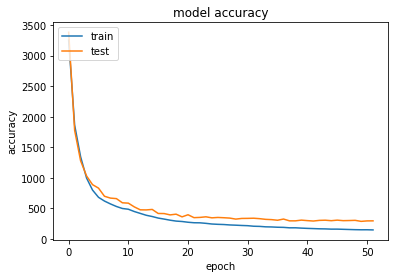

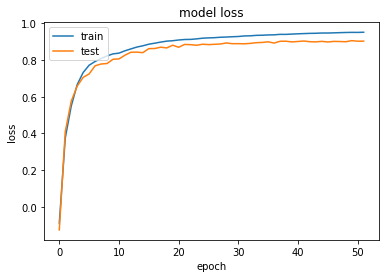

In [ ]:
# list all data in training
print(history.history.keys())

# summarize training for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize traning for loss
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def plot_limb(img, joints, i, j, color):
    """Function to plot the limbs"""
    cv.line(img, joints[i], joints[j], (255, 255, 255), thickness=2, lineType=16)
    cv.line(img, joints[i], joints[j], color, thickness=1, lineType=16)
    return img

def plot_joints(img, joints, original=True, text_scale=0.5):
    """Function to draw the joints"""
    h, w, c = img.shape
    # Connecting the joints
    if original:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 155, 70))

        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 155, 70))

        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 155, 70))

        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 155, 70))

        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 155, 70))

        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 155, 70))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 155, 70), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=2, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    else:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 70, 155))

        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 70, 155))

        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 70, 155))

        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 70, 155))

        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 70, 155))

        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)

        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 70, 155))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 70, 155), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=3, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    return img

In [ ]:
test = pd.read_csv('/content/FLIC DATASET/Pose_Dataset/test_joints_coords.csv', header = None, nrows=200)
test_img_ids = test.iloc[:,0].values

# load validation images
test_images = np.array([cv.imread('/content/FLIC DATASET/Pose_Dataset/test/{}'.format(x)) for x in test_img_ids])

# convert validation images to dtype float
test_images = test_images.astype(float)

# joints
test_joints = test.iloc[:,1:].values

# predict
predictions = model_final.predict(test_images, verbose = 0, batch_size=batch_size)

# folder to save the results
if not os.path.exists(os.path.join(os.getcwd(), '/content/test_plot')):
    os.mkdir('/content/test_plot')

for i, (ids, image, joint, pred) in enumerate(zip(test_img_ids, test_images, test_joints, predictions)):
    joints = joint.tolist()
    joints = list(zip(joints[0::2], joints[1::2]))
    # plot original joints
    image = plot_joints(image.astype(np.uint8), joints, original=True, text_scale=0.5)

    pred = pred.astype(np.uint8).tolist()
    pred = list(zip(pred[0::2], pred[1::2]))
    # plot predicted joints
    image = plot_joints(image.astype(np.uint8), pred, original=False, text_scale=0.5)
    # save resulting images with the same id
    plt.imsave('/content/test_plot/'+ids, image)

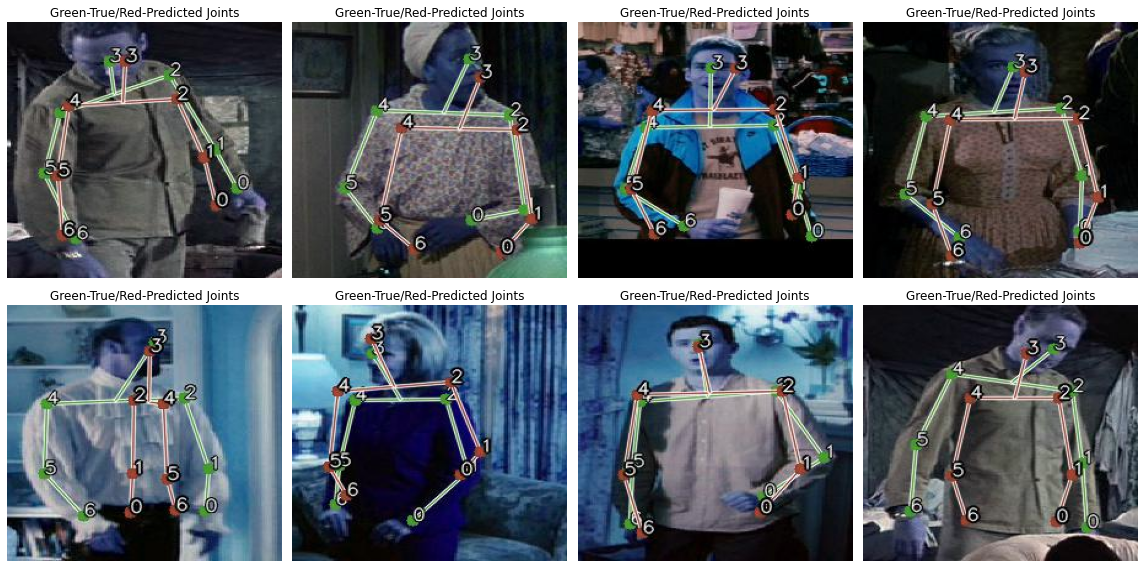

In [ ]:
import glob
image_list = glob.glob('/content/test_plot/*.jpg')[16:25]

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = cv.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Green-True/Red-Predicted Joints')

plt.tight_layout()
plt.show()

saving the model

In [ ]:
# save model
model_json = model_final.to_json()
# folder to save the results
with open("pose_estimation_model.json", "w") as json_file:
    json_file.write(model_json)

model_final.save_weights("pose_estimation_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Uploading a pic outside the test and train dataset
from google.colab import files
files.upload()

Saving man.jpg to man.jpg


{'man.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xf0\x00\xf0\x00\x00\xff\xed\x15\xc2Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00A\x1c\x01Z\x00\x03\x1b%G\x1c\x01Z\x00\x03\x1b%G\x1c\x02\x00\x00\x02\x00\x04\x1c\x027\x00\x0820180406\x1c\x02<\x00\x0b135053+0000\x1c\x02>\x00\x0820180406\x008BIM\x04%\x00\x00\x00\x00\x00\x10\x9d\xb9\xd2\xf4\xa6P\xf4\x1f\r\xe2\xd2\x9c\x98\xb1Y\x9b8BIM\x04:\x00\x00\x00\x00\x00\xf7\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0bprintOutput\x00\x00\x00\x05\x00\x00\x00\x00PstSbool\x01\x00\x00\x00\x00Inteenum\x00\x00\x00\x00Inte\x00\x00\x00\x00Img \x00\x00\x00\x0fprintSixteenBitbool\x00\x00\x00\x00\x0bprinterNameTEXT\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0fprintProofSetupObjc\x00\x00\x00\x15\x04\x1f\x040\x04@\x040\x04<\x045\x04B\x04@\x04K\x00 \x04F\x042\x045\x04B\x04>\x04?\x04@\x04>\x041\x04K\x00\x00\x00\x00\x00\nproofSetup\x00\x00\x00\x01\x00\x00\x00\x00Bltnenum\x00\x00\x00\x0cbuiltinProof\x00\x00\x00\tproofCMYK\x008BIM\x04;\x00\x00\x00\x0

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('pose_estimation_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights("pose_estimation_model.h5")
print("Loaded model from disk")


Loaded model from disk


[171.42833  184.44087  176.33134  145.8726   154.9597    80.44688
 101.87327   38.822212  65.633484  85.64543   54.820274 155.25322
  62.044872 194.266   ]


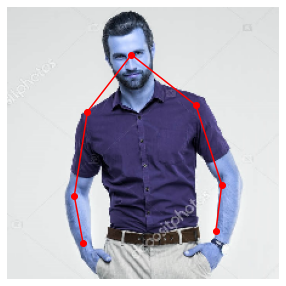

In [ ]:
def result(image):
    cords = loaded_model.predict(image.reshape(-1,224,224,3))[0]
    print(cords)
    x=[]; y=[]
    for i in range(0,len(cords), 2):
        x.append(cords[i]); y.append(cords[i+1])

    plt.figure(figsize= (5,5))
    plt.imshow(image);
    plt.plot(x,y,'ro-')
    plt.grid(False);plt.axis(False)

image= cv2.imread('/content/man.jpg')
image = cv.resize(image, (224, 224), interpolation=cv.INTER_NEAREST)
result(image)

# **2. Implementation of NN based Action Model**

In [ ]:
#Mounting my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzipping the action dataset and joint coordinates
!unzip '/content/drive/My Drive/Action_Dataset.zip' -d '/content'

Archive:  /content/drive/My Drive/Action_Dataset.zip
   creating: /content/Action_Dataset/
  inflating: /content/Action_Dataset/action_joints.csv  
  inflating: /content/Action_Dataset/hello1.jpg  
  inflating: /content/Action_Dataset/hello2.jpg  
  inflating: /content/Action_Dataset/hello3.jpg  
  inflating: /content/Action_Dataset/hello4.jpg  
  inflating: /content/Action_Dataset/hello5.jpg  
  inflating: /content/Action_Dataset/hello6.jpg  
  inflating: /content/Action_Dataset/hello7.jpg  
  inflating: /content/Action_Dataset/hello8.jpg  
  inflating: /content/Action_Dataset/hello9.jpg  
  inflating: /content/Action_Dataset/hello_test.jpg  
  inflating: /content/Action_Dataset/namaste1.jpg  
  inflating: /content/Action_Dataset/namaste2.jpg  
  inflating: /content/Action_Dataset/namaste3.jpg  
  inflating: /content/Action_Dataset/namaste4.jpg  
  inflating: /content/Action_Dataset/namaste5.jpg  
  inflating: /content/Action_Dataset/namaste6.jpg  
  inflating: /content/Action_Dataset

In [ ]:
#Unmounting the drive since it causes training to be slow.
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import SGD
from keras.callbacks import *
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#Augmenting the dataset to detect left hand Hello gesture too
Action_dataset = pd.read_csv('/content/Action_Dataset/action_joints.csv',header= None)

Action_dataset = Action_dataset.drop(0,axis=1)
Action_dataset = Action_dataset.drop(0,axis=0)

dataset_augmented= Action_dataset.iloc[:1,:]
dataset_augmented.loc[11,:]=Action_dataset.iloc[19,:]
dataset_augmented = dataset_augmented[[13,14,11,12,9,10,7,8,5,6,3,4,1,2,15]]
dataset_augmented

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,13,14,11,12,9,10,7,8,5,6,3,4,1,2,15
1,48,28,81,74,106,90,123,64,157,96,165,152,152,205,Hello
11,115,148,56,201,57,115,104,58,162,119,180,210,135,143,Namaste


In [ ]:
#Preparing the X values(joint coordinates) for training
dataset = pd.read_csv('/content/Action_Dataset/action_joints.csv',header= None)

dataset = dataset.drop(0,axis=1)
dataset = dataset.drop(0,axis=0)

dataset = dataset.append(dataset_augmented)
dataset.reset_index(drop=True, inplace=True)

#Preparing the Y values(action label) for training
target=dataset.iloc[:,14]
target=target.replace({'Hello': 0, 'Namaste': 1})
dataset

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,152,205,165,152,157,96,123,64,106,90,81,74,48,28,Hello
1,142,184,144,133,134,93,105,56,86,84,60,65,45,19,Hello
2,155,202,151,149,141,109,101,71,60,105,47,73,53,40,Hello
3,167,216,159,161,165,111,147,66,87,88,41,102,65,49,Hello
4,140,194,137,144,131,100,105,70,77,92,60,75,60,37,Hello
5,189,218,174,169,157,121,120,84,98,117,67,94,43,46,Hello
6,184,188,168,137,153,96,120,67,84,92,69,70,76,25,Hello
7,179,161,171,118,162,68,131,36,114,64,85,49,48,27,Hello
8,154,180,160,152,143,101,112,62,76,97,55,79,82,36,Hello
9,151,57,148,103,120,93,105,71,78,101,65,143,60,188,Hello


In [ ]:
X = dataset.iloc[:,:14]
X= X.astype('float32')

y = target.values.reshape(-1,1)
enc= OneHotEncoder()
y= enc.fit_transform(y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
model =Sequential()

model.add(Dense(1024*2, input_shape=[14], activation= 'relu', activity_regularizer='l2', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(14, activation= 'relu', activity_regularizer='l2'))
model.add(BatchNormalization())

model.add(Dense(2, activation= 'sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#early_stopping= EarlyStopping(monitor= 'val_accuracy', mode= 'max', restore_best_weights= True, patience=20)
training = model.fit(X_train,y_train, validation_data =(X_test, y_test), epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 4428.3618 - accuracy: 0.2941 - val_loss: 3582.4382 - val_accuracy: 0.6000
Epoch 2/30
1/1 [==============================] - 0s 30ms/step - loss: 3912.3750 - accuracy: 0.7647 - val_loss: 3154.0459 - val_accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - 0s 27ms/step - loss: 3447.5713 - accuracy: 1.0000 - val_loss: 2773.2319 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 31ms/step - loss: 3031.0671 - accuracy: 1.0000 - val_loss: 2433.6868 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 40ms/step - loss: 2658.8916 - accuracy: 1.0000 - val_loss: 2131.8218 - val_accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 0s 30ms/step - loss: 2327.4841 - accuracy: 1.0000 - val_loss: 1863.9125 - val_accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 0s 34ms/step - loss: 2033.2643 - accuracy: 0.9412 - val_loss: 1626.8263 - val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


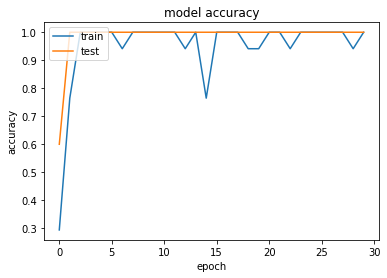

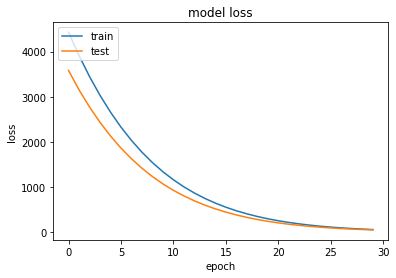

In [ ]:
# list all data in training
print(training.history.keys())

# summarize training for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize traning for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# make class predictions with the model
predictions = np.argmax(model.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=1)

Test_accuracy = (accuracy_score(y_test, predictions)*100 ).round(2)
print("The test accuracy is {}".format(Test_accuracy))

The test accuracy is 100.0


In [ ]:
# save model
model_json = model.to_json()
# folder to save the results
with open("xy_actions_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("xy_actions_model.h5")

## **b) Model that trains on the Euclidean distance of the joint coordinates**

In [ ]:
def joint_coordinates(joint):
    distance = []
    # Defining the xy-coordinates of each body joint
    j1 = np.asarray([joint[0],joint[1]])
    j2 = np.asarray([joint[2],joint[3]])
    j3 = np.asarray([joint[4],joint[5]])
    j4 = np.asarray([joint[6],joint[7]])
    j5 = np.asarray([joint[8],joint[9]])
    j6 = np.asarray([joint[10],joint[11]])
    j7 = np.asarray([joint[12],joint[13]])

    distance.append(np.linalg.norm(j1 - j2))
    distance.append(np.linalg.norm(j2 - j3))
    distance.append(np.linalg.norm(j3 - j4))
    distance.append(np.linalg.norm(j4 - j5))
    distance.append(np.linalg.norm(j5 - j6))
    distance.append(np.linalg.norm(j6 - j7))
    distance = distance/max(distance)
    return distance

In [ ]:
dist_df = []

#Getting the normalized distance between joints for each row in dataset
for row in range(0,len(dataset)):
  joints = np.asarray(dataset.iloc[row,:14])
  joints = joints.astype('int')
  dist_df.append(joint_coordinates(joints))

dist_df = pd.DataFrame(dist_df)
dist_df = dist_df.round(2)
dist_df[6]=target
dist_df.head()

,0,1,2,3,4,5,6
0,0.96,1.00,0.82,0.55,0.52,1.00,0
1,1.00,0.81,0.92,0.66,0.63,0.95,0
2,0.96,0.75,1.00,0.97,0.63,0.61,0
3,0.87,0.79,0.76,1.00,0.75,0.91,0
4,1.00,0.89,0.79,0.71,0.48,0.76,0


In [ ]:
X = dist_df.iloc[:,:6]
X= X.astype('float32')

y = dataset[15].values.reshape(-1,1)
enc= OneHotEncoder()
y= enc.fit_transform(y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)


In [ ]:
dist_model =Sequential()

dist_model.add(Dense(1024*2, input_shape=[6], activation= 'relu', activity_regularizer='l2', kernel_initializer='TruncatedNormal'))
dist_model.add(BatchNormalization())
dist_model.add(Dropout(0.5))
dist_model.add(Dense(256, activation= 'relu', activity_regularizer='l2'))
dist_model.add(BatchNormalization())
dist_model.add(Dense(2, activation= 'sigmoid'))


In [ ]:
dist_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping= EarlyStopping(monitor= 'val_accuracy', mode= 'max', restore_best_weights= True, patience=20)
H = dist_model.fit(X_train,y_train, validation_data =(X_test, y_test), epochs=50, callbacks= [early_stopping])

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.9805 - accuracy: 0.1579 - val_loss: 0.7233 - val_accuracy: 0.6667
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5705 - accuracy: 0.9474 - val_loss: 0.6852 - val_accuracy: 0.6667
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.4706 - accuracy: 1.0000 - val_loss: 0.6648 - val_accuracy: 0.6667
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 0.5005 - accuracy: 1.0000 - val_loss: 0.6520 - val_accuracy: 0.6667
Epoch 5/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5197 - accuracy: 1.0000 - val_loss: 0.6434 - val_accuracy: 0.6667
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5185 - accuracy: 1.0000 - val_loss: 0.6386 - val_accuracy: 0.6667
Epoch 7/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5372 - accuracy: 1.0000 - val_loss: 0.6362 - val_accuracy: 0.6667
Epoch 8/50
1/1 [=============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


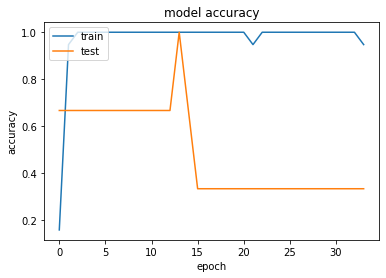

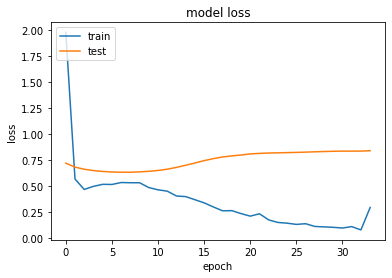

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(H.history.keys())
# summarize training for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = np.argmax(dist_model.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=1)

#Evaluating the model
Test_accuracy = (accuracy_score(y_test, predictions)*100 ).round(2)
print("The test accuracy is {}".format(Test_accuracy))

The test accuracy is 100.0


In [ ]:
# save model
model_json = dist_model.to_json()
# folder to save the results
with open("dist_actions_model.json", "w") as json_file:
    json_file.write(model_json)

dist_model.save_weights("dist_actions_model.h5")

# **3. Implementation  of  Action  Recognition  in  videos  using  pose  joints  estimated  by  the  CNN model**

In [ ]:
## Load saved pose estimation model
from keras.models import model_from_json

# load json and create model
json_file = open('/content/pose_estimation_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights("/content/pose_estimation_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
## Load saved action model
from keras.models import model_from_json

# load json and create model
json_file = open('/content/xy_actions_model.json', 'r')
action_model_json = json_file.read()
json_file.close()
action_model = model_from_json(action_model_json)

# load weights
action_model.load_weights("/content/xy_actions_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import os
path=os.getcwd()
print("Current Directory",os.getcwd())
newDir=path+'/dataset/'
#os.mkdir(newDir)
print("New Directory created as /content/dataset/")

Current Directory /content
New Directory created as /content/dataset/


[[0.58624107 0.57655555]]
[[0.590164   0.57361424]]
[[0.5894136 0.5741612]]
[[0.60265374 0.5593397 ]]
[[0.6154103  0.54482734]]
[[0.63107365 0.5280803 ]]
[[0.6660883 0.4794779]]
[[0.6674863  0.47514555]]
[[0.6602625  0.49803922]]
[[0.6341509 0.5257311]]
[[0.601364  0.5633525]]


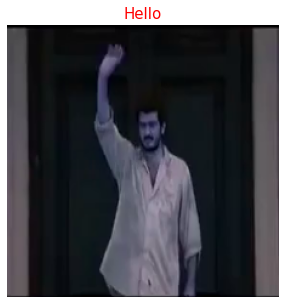

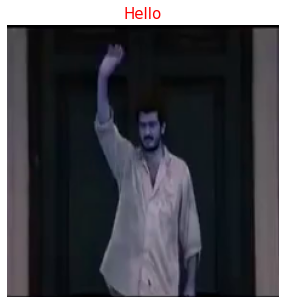

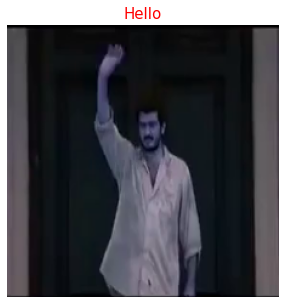

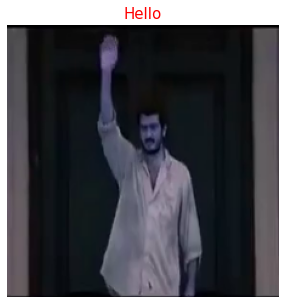

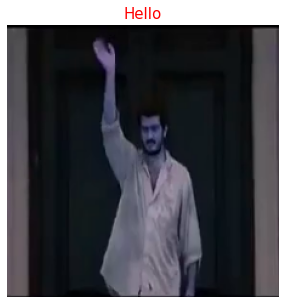

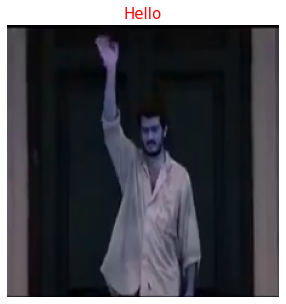

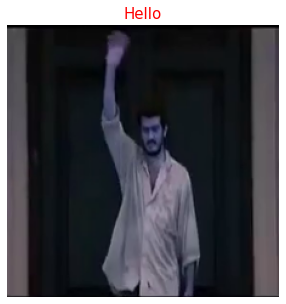

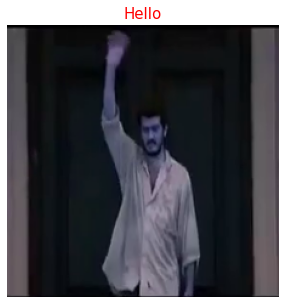

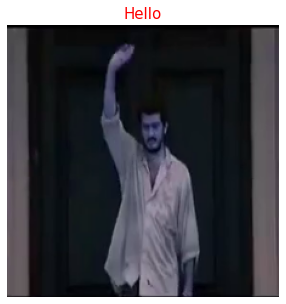

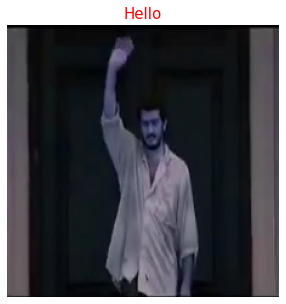

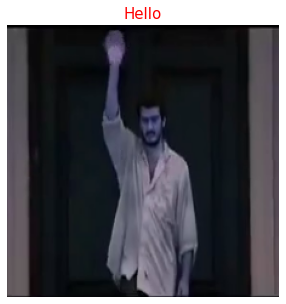

In [ ]:
import cv2
#Capturing from Video File
cap = cv2.VideoCapture('/content/Action_Dataset/Waving.mp4')

# Get the frames per second
fps = cap.get(cv2.CAP_PROP_FPS)

# Get the total numer of frames to be counted in the video.
frame_number = 0
frame_count = fps*10  #I am taking first 11 frames i.e for 0 to fps*10 with intervals of  fps

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
#Setting the Target Size of frame that is to be captured
size = (224,224)
image_count = 0

# Check if camera/VideoFile opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

# Read until video is completed
while cap.isOpened() and (frame_number <= frame_count):

    frame_number += fps
    ret, frame = cap.read()
    frame = cv2.resize(frame, size)

    if ret == True:
            #Using pose_model to predict joints cordinates
            cords = loaded_model.predict(frame.reshape(-1,224,224,3))[0]

            #Next to it Using clf_model to predicting labels Namste/Hello
            x=[]; y=[]
            for i in range(0,14, 2):
                x.append(cords[i]); y.append(cords[i+1])

            cords= cords.reshape((-1,14))

            #dist_data = joint_coordinates(cords[0])   #Use these commands if using euclidean dist model
            #dist_data = dist_data.reshape((-1,6))
            #action = np.argmax(action_model.predict(dist_data), axis=-1)

            action = action_model.predict(cords)
            print(action_model.predict(cords))
            if (action==0).all():
                action = 'Namaste'
            else:
                action = 'Hello'

            plt.figure(figsize= (5,5))
            plt.imshow(frame);
            plt.title(action, size= 15, color= 'red')
            plt.grid(False);plt.axis(False)

[136.88568  146.87468  176.12415  181.6699   149.18709   97.10653
  89.73642   39.61802   39.63869  104.99011   33.210644 198.6281
  96.43641  165.74913 ]


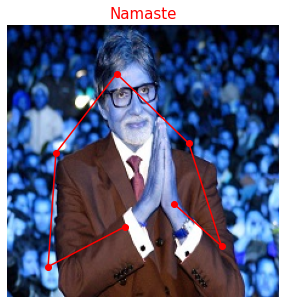

In [ ]:
import cv2
def plot_result(image):
    cords = loaded_model.predict(image.reshape(-1,224,224,3))[0]
    print(cords)
    x=[]; y=[]
    for i in range(0,len(cords), 2):
        x.append(cords[i]); y.append(cords[i+1])

    cords= cords.reshape((-1,14))

    #dist_data = joint_coordinates(cords[0])   #Use these commands if using euclidean dist model
    #dist_data = dist_data.reshape((-1,6))
    #action = np.argmax(action_model.predict(dist_data), axis=-1)

    action = action_model.predict(cords)

    if (action==0).all():
        action = 'Hello'
    else:
        action = 'Namaste'

    plt.figure(figsize= (5,5))
    plt.imshow(image);
    plt.plot(x,y,'ro-')
    plt.title(action, size= 15, color= 'red')
    plt.grid(False);plt.axis(False)

image= cv2.imread('/content/Action_Dataset/namaste_test.jpg')
plot_result(image)

### Project Solutions:
#### 1.Human Pose Estimation:
Pose estimation is achieved through the implementation of a CNN model. Transfer learning has been utilized for detection of body joints. VGG16 pre-trained model is used as the convolution base. The top model is customized for the problem. Training takes place in 2 groups. I was able to obtain a **R2 score of 0.92** on the test data, which seems accurate enough.


#### 2.Action Recognition:
I created two action recognition models.
 * **xy_actions_model.h5:** Model that trains on the (X,Y) coordinates of joints.

     This Neural network was built by directly considering x and y coordinates as features and action label as target. This model gave me a **validation accuracy of 100%.** But humans can appear on any scale in a real scenario, considering raw coordinates as features is not a good idea. Therefore, I developed the below model.
 * **dist_actions_model.h5:** Model that trains on the Euclidean distance of the joint coordinates

     For this model I have extracted the distance between every joint and further normalized the distance features. These distance features were considered for training the action recognition model. I was able to achieve a **validation accuracy of 100%.** However, this model wasn't stable, ie.. this model occasionally did return a 50% accuracy.

#### 3.Implementation of Action Recognition in videos using pose joints estimated by the CNN model
The **'pose_estimation_model.h5'** has estimated Pose fairly accurately and **'xy_actions_model.h5'** has recognized the action correctly as 'Namaste'.